In [1]:
import yfinance as yf
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

# A list of classic pairs: [Coke/Pepsi, Visa/Mastercard, Exxon/Chevron]
pairs_to_test = [('KO', 'PEP'), ('V', 'MA'), ('XOM', 'CVX')]

print("Running Cointegration Scanner...\n")

for asset1, asset2 in pairs_to_test:
    # 1. Fetch Data
    data = yf.download([asset1, asset2], start='2024-01-01', end='2026-01-01', progress=False)['Close'].dropna()
    
    # 2. Run OLS Regression to find Beta
    X = sm.add_constant(data[asset2])
    Y = data[asset1]
    ols_model = sm.OLS(Y, X).fit()
    beta = ols_model.params.iloc[1] # .iloc[1] safely grabs the slope (Beta)
    
    # 3. Calculate Spread
    spread = Y - beta * data[asset2]
    
    # 4. Run ADF Test
    adf_result = adfuller(spread)
    p_value = adf_result[1]
    
    # 5. Output Results
    print(f"Pair: {asset1} & {asset2}")
    print(f"Beta: {beta:.4f} | P-Value: {p_value:.4f}")
    
    if p_value < 0.05:
        print("✅ STATIONARY - Tradable Pair\n")
    else:
        print("❌ NON-STATIONARY - Do Not Trade\n")

Running Cointegration Scanner...

Pair: KO & PEP
Beta: -0.2126 | P-Value: 0.1242
❌ NON-STATIONARY - Do Not Trade

Pair: V & MA
Beta: 0.6656 | P-Value: 0.1440
❌ NON-STATIONARY - Do Not Trade

Pair: XOM & CVX
Beta: 0.5091 | P-Value: 0.2588
❌ NON-STATIONARY - Do Not Trade



In [2]:
import numpy as np
import yfinance as yf
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

# 1. Shorter Timeframe: Last 6 months of market data
start_date = '2025-08-01'
end_date = '2026-02-19'

# Added Financials (JPM/BAC) and Gold (GLD/GDX) to the classic pairs
pairs_to_test = [
    ('KO', 'PEP'), 
    ('V', 'MA'), 
    ('XOM', 'CVX'),
    ('JPM', 'BAC'), # JPMorgan & Bank of America
    ('GLD', 'GDX')  # Gold & Gold Miners
]

print("Running Log-Price Scanner (6-Month Window)...\n")

for asset1, asset2 in pairs_to_test:
    # 2. Fetch Data
    data = yf.download([asset1, asset2], start=start_date, end=end_date, progress=False)['Close'].dropna()
    
    # 3. Convert to Logarithmic Prices (The Quant Fix)
    log_data = np.log(data)
    
    # 4. OLS Regression on Log Prices
    X = sm.add_constant(log_data[asset2])
    Y = log_data[asset1]
    ols_model = sm.OLS(Y, X).fit()
    beta = ols_model.params.iloc[1] 
    
    # 5. Calculate Log Spread
    spread = Y - beta * log_data[asset2]
    
    # 6. Run ADF Test
    adf_result = adfuller(spread)
    p_value = adf_result[1]
    
    print(f"Pair: {asset1} & {asset2}")
    print(f"Beta: {beta:.4f} | P-Value: {p_value:.4f}")
    
    if p_value < 0.05:
        print("✅ STATIONARY - Tradable Pair Found!\n")
    else:
        print("❌ NON-STATIONARY - Do Not Trade\n")

Running Log-Price Scanner (6-Month Window)...

Pair: KO & PEP
Beta: 0.7993 | P-Value: 0.2447
❌ NON-STATIONARY - Do Not Trade

Pair: V & MA
Beta: 0.6725 | P-Value: 0.0495
✅ STATIONARY - Tradable Pair Found!

Pair: XOM & CVX
Beta: 1.4664 | P-Value: 0.4897
❌ NON-STATIONARY - Do Not Trade

Pair: JPM & BAC
Beta: 0.5716 | P-Value: 0.0030
✅ STATIONARY - Tradable Pair Found!

Pair: GLD & GDX
Beta: 0.6634 | P-Value: 0.0268
✅ STATIONARY - Tradable Pair Found!



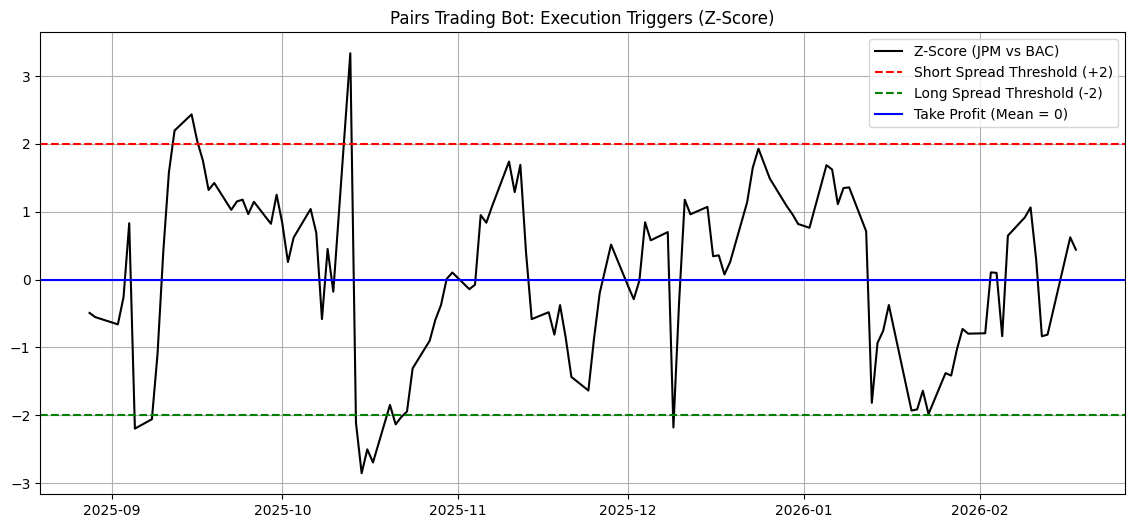

In [3]:
import pandas as pd
import numpy as np
import yfinance as yf
import statsmodels.api as sm
import matplotlib.pyplot as plt

# 1. Isolate the winning pair and fetch the data
asset1, asset2 = 'JPM', 'BAC'
data = yf.download([asset1, asset2], start='2025-08-01', end='2026-02-19', progress=False)['Close'].dropna()

log_data = np.log(data)

# 2. Recalculate Beta for this specific pair
X = sm.add_constant(log_data[asset2])
Y = log_data[asset1]
ols_model = sm.OLS(Y, X).fit()
beta = ols_model.params.iloc[1]

# 3. Calculate the Log Spread
spread = Y - beta * log_data[asset2]

# 4. Calculate the Rolling Z-Score (20-day window)
window = 20
rolling_mean = spread.rolling(window=window).mean()
rolling_std = spread.rolling(window=window).std()

z_score = (spread - rolling_mean) / rolling_std

# 5. Plot the Z-Score with Trading Thresholds
plt.figure(figsize=(14, 6))
plt.plot(z_score.index, z_score, color='black', label=f'Z-Score ({asset1} vs {asset2})')

# The Bot's Triggers
plt.axhline(2.0, color='red', linestyle='--', label='Short Spread Threshold (+2)')
plt.axhline(-2.0, color='green', linestyle='--', label='Long Spread Threshold (-2)')
plt.axhline(0, color='blue', linestyle='-', label='Take Profit (Mean = 0)')

plt.title('Pairs Trading Bot: Execution Triggers (Z-Score)')
plt.legend()
plt.grid(True)
plt.show()


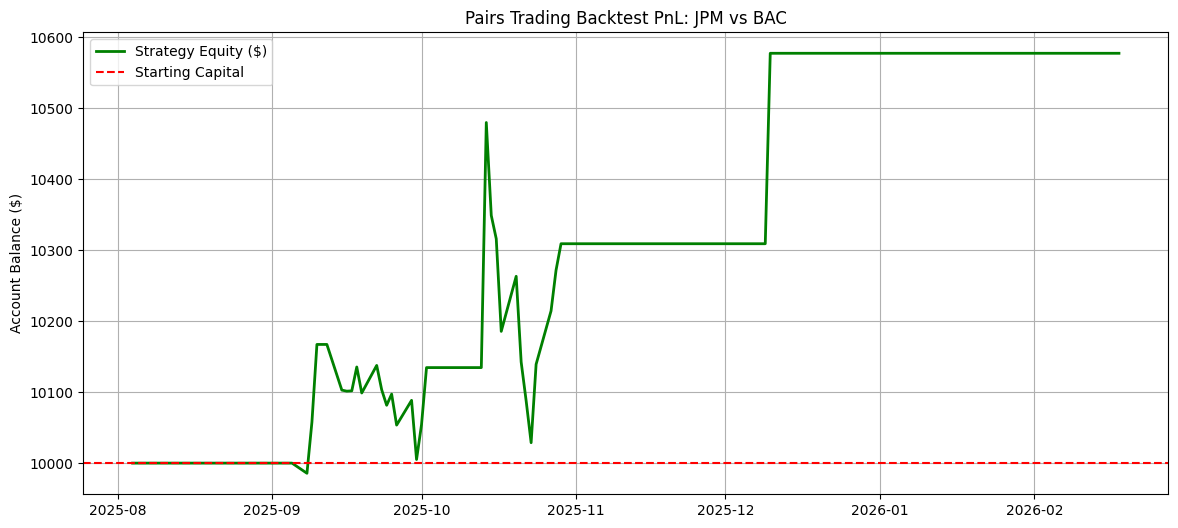

Total Simulated Profit: $577.73


In [4]:
# 1. Create a DataFrame to hold our backtesting data
strat = pd.DataFrame(index=z_score.index)
strat['z_score'] = z_score

# 2. Generate Trading Signals (The Triggers)
# We enter when the z-score passes +/- 2.0
strat['long_entry'] = strat['z_score'] < -2.0
strat['short_entry'] = strat['z_score'] > 2.0

# We exit when the z-score returns to the mean (we use 0.5 to give it breathing room)
strat['exit_signal'] = abs(strat['z_score']) < 0.5

# 3. Translate Signals to Positions (+1 for Long, -1 for Short, 0 for Flat)
strat['target_position'] = np.nan
strat.loc[strat['long_entry'], 'target_position'] = 1
strat.loc[strat['short_entry'], 'target_position'] = -1
strat.loc[strat['exit_signal'], 'target_position'] = 0

# Forward-fill the positions so we "hold" the trade until an exit signal hits
strat['position'] = strat['target_position'].ffill().fillna(0)

# 4. Calculate the Return of the Spread
# Because we used logarithmic prices, the daily difference in the spread 
# represents the daily percentage return of our synthetic portfolio.
strat['spread_return'] = spread.diff()

# 5. Calculate Strategy PnL (PREVENTING LOOKAHEAD BIAS)
# We MUST shift the position by 1. If a signal triggers at today's close, 
# we only capture the return starting tomorrow. 
strat['strategy_log_return'] = strat['position'].shift(1) * strat['spread_return']

# 6. Calculate the Equity Curve (Assuming a $10,000 starting account)
initial_capital = 10000
strat['cumulative_log_return'] = strat['strategy_log_return'].cumsum()
strat['equity_curve'] = initial_capital * np.exp(strat['cumulative_log_return'])

# 7. Plot the Result
plt.figure(figsize=(14, 6))
plt.plot(strat.index, strat['equity_curve'], color='green', linewidth=2, label='Strategy Equity ($)')
plt.axhline(initial_capital, color='red', linestyle='--', label='Starting Capital')
plt.title('Pairs Trading Backtest PnL: JPM vs BAC')
plt.ylabel('Account Balance ($)')
plt.legend()
plt.grid(True)
plt.show()

# Print Final PnL
total_profit = strat['equity_curve'].iloc[-1] - initial_capital
print(f"Total Simulated Profit: ${total_profit:.2f}")

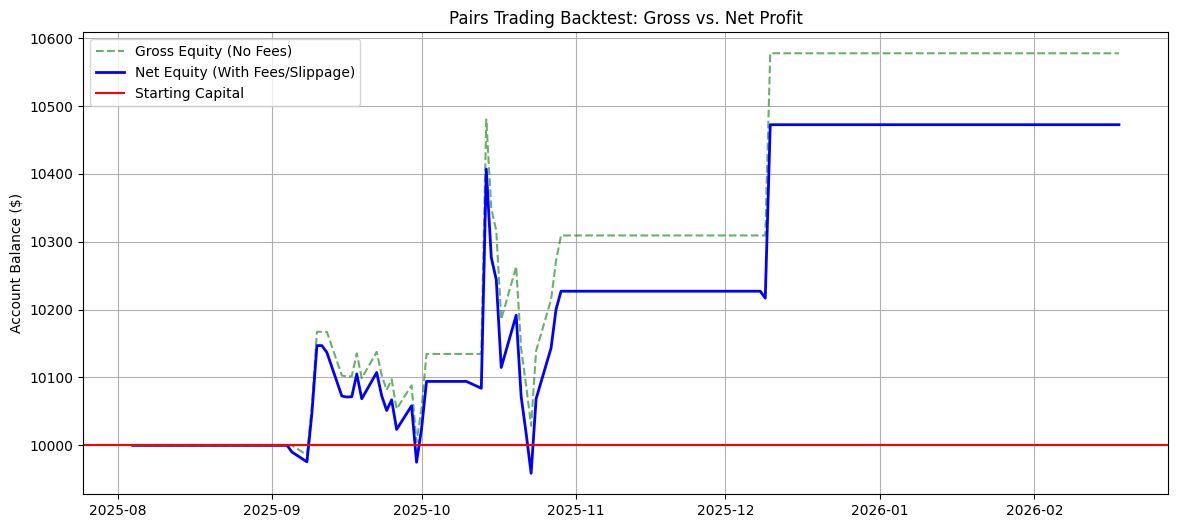

Gross Profit: $577.73
Net Profit (After Fees): $472.48
Annualized Sharpe Ratio: 1.18


In [5]:
import numpy as np

# 1. Define Real-World Frictions
# Assume 0.10% total cost per transaction (Slippage + Broker Commissions)
transaction_cost_pct = 0.0010 

# 2. Calculate "Turnover" (How many shares we bought/sold)
# If position goes 0 -> 1, turnover is 1. If 1 -> -1, turnover is 2.
strat['turnover'] = strat['position'].diff().abs().fillna(0)

# 3. Deduct Fees from the Daily Returns
# We subtract the cost whenever the turnover is > 0
strat['strategy_net_return'] = strat['strategy_log_return'] - (strat['turnover'] * transaction_cost_pct)

# 4. Recalculate the Net Equity Curve
strat['net_cumulative_return'] = strat['strategy_net_return'].cumsum()
strat['net_equity_curve'] = initial_capital * np.exp(strat['net_cumulative_return'])

# 5. Calculate the Annualized Sharpe Ratio
# We assume 252 trading days in a year for equities
# Assuming a risk-free rate of 0% for simplicity in this short-term environment
daily_mean_return = strat['strategy_net_return'].mean()
daily_volatility = strat['strategy_net_return'].std()

annualized_sharpe = (daily_mean_return / daily_volatility) * np.sqrt(252)

# 6. Plot Gross vs. Net Profit
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(strat.index, strat['equity_curve'], color='green', linestyle='--', alpha=0.6, label='Gross Equity (No Fees)')
plt.plot(strat.index, strat['net_equity_curve'], color='blue', linewidth=2, label='Net Equity (With Fees/Slippage)')
plt.axhline(initial_capital, color='red', linestyle='-', label='Starting Capital')

plt.title('Pairs Trading Backtest: Gross vs. Net Profit')
plt.ylabel('Account Balance ($)')
plt.legend()
plt.grid(True)
plt.show()

# Print the final Quant Metrics
net_profit = strat['net_equity_curve'].iloc[-1] - initial_capital
print(f"Gross Profit: ${total_profit:.2f}")
print(f"Net Profit (After Fees): ${net_profit:.2f}")
print(f"Annualized Sharpe Ratio: {annualized_sharpe:.2f}")